# Sandbox

## Simulation

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import sys
import os
import importlib

In [14]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps

In [71]:
importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

In [83]:
Hsys, params = ps.get_Hsys(N=3, offset=1e0, dipolar_strength=1e2, return_all=True)

In [84]:
X, Y, Z = ps.get_collective_spin(N=3)

In [85]:
Hsys

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ -66.00392416    0.            0.            0.            0.
     0.            0.            0.        ]
 [   0.         -513.59814556  -53.6894204     0.         -169.00200105
     0.            0.            0.        ]
 [   0.          -53.6894204   407.76374958    0.          290.91193365
     0.            0.            0.        ]
 [   0.            0.            0.          174.92720979    0.
   290.91193365 -169.00200105    0.        ]
 [   0.         -169.00200105  290.91193365    0.          176.27149622
     0.            0.            0.        ]
 [   0.            0.            0.          290.91193365    0.
   404.68527901  -53.6894204     0.        ]
 [   0.            0.            0.         -169.00200105    0.
   -53.6894204  -513.60856464    0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.          -70.43710023]]

In [88]:
output = qt.mesolve(Hsys, X, tlist=np.linspace(0, 15e-2, 500), e_ops=[X, Y, Z])

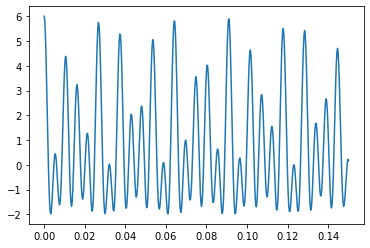

In [89]:
plt.plot(output.times, output.expect[0])

In [90]:
params

(array([0.56365476, 0.13010873, 0.8971216 ]),
 0.20856764728178212,
 array([[-127.71305054, -145.45596682,   84.50100052],
        [ -17.43951414,  101.06205672,   26.8447102 ],
        [-181.97074045,  -41.18745734,  -14.02630326]]))

In [123]:
pulses = ps.get_pulses(Hsys, X, Y, Z, pulse_width=1e-5, delay=1e-4, phase_transient=0)

In [122]:
(pulses[1] * pulses[1] * pulses[1] * pulses[1]).tr()/8

(-0.9957933313517151+3.114655634936449e-05j)

In [91]:
ps.get_pulses

<function pulse_sequences.get_pulses(Hsys, X, Y, Z, pulse_width=0.0001, delay=0.001, rot_error=0, phase_transient=0, rng=None)>

## ML

In [1]:
import torch
import numpy as np
import torch.multiprocessing as mp
from time import sleep

In [45]:
def worker(proc_num, queue):
    for _ in range(6000):
        if _ % 500 == 0:
            print(f'in {proc_num} on iteration {_}')
        rng = np.random.default_rng()
        length = rng.integers(48)
        state = rng.random(size=(length, 6))
        probs = rng.random(size=(5,))
        value = rng.random(size=(1,))
        datum = (state, probs, value)
        queue.put(datum)
#         with lock:
#             if len(buffer) < buffer_size:
#                 buffer.append(datum)
#                 index.value += 1
#             else:
#                 buffer[index.value] = datum
#                 index.value += 1
#             if index.value >= buffer_size:
#                 index.value = 0
    return


def checker(queue, output, buffer_size=24000):
    buffer = []
    index = 0
    while len(buffer) < buffer_size:
        if queue.empty():
            sleep(1)
            continue
        buffer.append(queue.get())
        index += 1
    output.put(buffer)

In [2]:
if __name__ == '__main__':
    # TODO start processes, try adding 450 * 48 * (tensor, tensor, tensor) to shared list
    # and see if I run into similar issues...
    with mp.Manager() as manager:
        queue = manager.Queue()
        output = manager.Queue()
#         length = manager.Value('i', 0)
#         index = manager.Value('i', 0)
#         lock = manager.Lock()
        workers = []
        for i in range(4):
            w = mp.Process(target=worker, args=(i, queue))
            w.start()
            workers.append(w)
        w = mp.Process(target=checker, args=(queue, output))
        w.start()
        workers.append(w)
        for w in workers:
            w.join()
        print('all processes joined')
#         buffer = list(buffer)
#         index = index.value
        buffer = output.get()

In [41]:
buffer[2][2]

array([0.54937819])

In [47]:
[a[2] for a in buffer[:10]]

[array([0.76290919]),
 array([0.15618292]),
 array([0.79988231]),
 array([0.24052051]),
 array([0.95798373]),
 array([0.92766788]),
 array([0.49542138]),
 array([0.11634498]),
 array([0.28900658]),
 array([0.93548941])]

In [48]:
len(buffer)

24000

In [3]:
np.random.gamma(.3, 1, 5)

array([4.51142846e-05, 1.63684981e-06, 1.90767475e-01, 1.66719882e-01,
       1.15576553e-09])

In [4]:
rng = np.random.default_rng()

In [25]:
rng.gamma(.3, 1, 5)

array([0.04235174, 0.17385871, 0.00208078, 0.00103263, 0.00506793])

In [26]:
rng.dirichlet([1e-1] * 5)

array([2.93925569e-03, 9.96016686e-01, 1.04404191e-03, 5.75735218e-20,
       1.66749759e-08])